In [29]:
!pip install -q -r requirements.txt

In [30]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler

### 1. Loading and Exploring Data

In [31]:
df = pd.read_csv('data/processed/ChurnModelling_Binning_Applied.csv')
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenureBins
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,New customers
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Established
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,New customers
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Established
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,New customers


In [32]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
tenureBins          0
dtype: int64

In [33]:
# --- PhoneServiceBins ---
df['PhoneServiceBins'] = (
    df['PhoneService'].map({'No': 0, 'Yes': 1}) +
    df['MultipleLines'].map({'No phone service': 0, 'No': 1, 'Yes': 2, })
)

# --- InternetServiceBins ---
df['InternetServiceBins'] = (
    # InternetService_No is boolean, so map with True/False not strings
    # changed the code so that InterbetService will not be binned and encoded
    # since fiber optic customers are less likely to leave we can give that feature a higher score
    df['InternetService'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2}) +
    df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']]
    .apply(lambda col: col.map({'No internet service': 0, 'No': 1, 'Yes': 2, }))
    .sum(axis=1)
)

In [34]:
df.drop(columns=[
    'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'InternetService'
], inplace=True)
df.head(1)

,gender,SeniorCitizen,Partner,Dependents,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenureBins,PhoneServiceBins,InternetServiceBins
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,New customers,0,8


### 2. Build Scikit-learn Pipelines

In [35]:
nominal_features = ['gender', 'PaymentMethod']
ordinal_features = ['tenureBins', 'Contract', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']
numerical_features = ['MonthlyCharges', 'TotalCharges', 'PhoneServiceBins', 'InternetServiceBins']
remainder_features = ['SeniorCitizen']

numerical_transformer = Pipeline(
                                steps=[
                                    ('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', RobustScaler())
                                ]
)

nominal_transformer = Pipeline(
                                steps=[
                                    ('imputer', SimpleImputer(
                                                            strategy='constant',
                                                            fill_value='missing'
                                                            )),
                                    ('encoder', OneHotEncoder())
                                ]
)

tenure_bin_order = ['New', 'Established', 'Loyal'] 
contract_order = ['Month-to-month', 'One year', 'Two year']
partner_order = ['No', 'Yes']
dependents_order = ['No', 'Yes']
paperless_billing_order = ['No', 'Yes']
churn_order = ['No', 'Yes']

ordinal_transformer = Pipeline(
                                steps=[
                                    ('imputer', SimpleImputer(
                                                            strategy='constant', 
                                                            fill_value='missing'
                                                            )),

                                    ('encoder', OrdinalEncoder(
                                        categories=[tenure_bin_order, contract_order, churn_order,
                                                    partner_order, dependents_order, paperless_billing_order],
                                        handle_unknown='use_encoded_value', # Handle new values
                                        unknown_value=-1 # Assign -1 to new/unknown values
                                    ))
                                ]
)

preprocessor = ColumnTransformer(
                                transformers=[
                                            ('num', numerical_transformer, numerical_features),
                                            ('nom', nominal_transformer, nominal_features),
                                            ('ord', ordinal_transformer, ordinal_features)
                                        ],
                                remainder='drop'
)

nominal_feature_names = []
for feature in nominal_features:
    unique_values = df[feature].unique()
    nominal_feature_names.extend([f"{feature}_{val}" for val in unique_values])

#nominal_feature_names

df_cp = df.copy()
df_transformed = pd.DataFrame(
                            preprocessor.fit_transform(df_cp),
                            columns = numerical_features + nominal_feature_names + ordinal_features
)
# Add back the remiander features
df_remainder = df[remainder_features]
df_pp = pd.concat(
                [df_transformed, df_remainder],
                axis=1
)

df_transformed

,MonthlyCharges,TotalCharges,PhoneServiceBins,InternetServiceBins,gender_Female,gender_Male,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),tenureBins,Contract,Partner,Dependents,PaperlessBilling,Churn
0,-0.745170,-0.402798,-2.0,-0.25,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0
1,-0.246550,0.146087,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.303588,-0.379687,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,1.0
3,-0.516099,0.131698,-2.0,0.25,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.006440,-0.366848,0.0,-0.25,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.265869,0.175898,1.0,0.75,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7039,0.604416,1.761589,1.0,0.75,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0
7040,-0.749770,-0.309352,-2.0,-0.25,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,1.0,1.0,0.0
7041,0.074517,-0.321114,1.0,-0.25,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,1.0,1.0


In [36]:
df_pp

,MonthlyCharges,TotalCharges,PhoneServiceBins,InternetServiceBins,gender_Female,gender_Male,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),tenureBins,Contract,Partner,Dependents,PaperlessBilling,Churn,SeniorCitizen
0,-0.745170,-0.402798,-2.0,-0.25,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0
1,-0.246550,0.146087,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
2,-0.303588,-0.379687,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,1.0,0
3,-0.516099,0.131698,-2.0,0.25,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
4,0.006440,-0.366848,0.0,-0.25,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.265869,0.175898,1.0,0.75,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0
7039,0.604416,1.761589,1.0,0.75,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0
7040,-0.749770,-0.309352,-2.0,-0.25,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,1.0,1.0,0.0,0
7041,0.074517,-0.321114,1.0,-0.25,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,1.0,1.0,1


In [37]:
df_pp.to_csv(
            'data/processed/X_Transformed.csv', 
            index=False
            )

### 3. Handle Class Imbalance

In [38]:
X = df_pp.drop(columns=['Churn'])
Y = df_pp['Churn']

In [39]:
"""
chrun - 1000
non-churn - 9000

upsample - (churn) 1000 -> 9000
downsamping - (non-churn) 9000 -> 1000
"""
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, Y,
                                                    test_size=0.2,
                                                    random_state=42
)


In [40]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

Text(0, 0.5, 'Count')

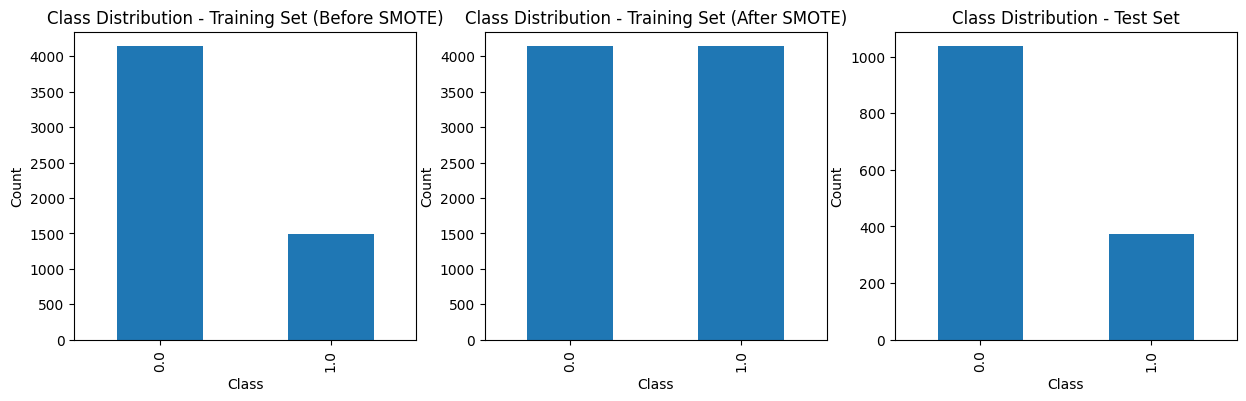

In [41]:
plt.figure(figsize=(15, 4))

# Before SMOTE
plt.subplot(131)
Y_train.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(132)
Y_train_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution - Training Set (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')

# Test Set
plt.subplot(133)
Y_test.value_counts().plot(kind='bar')
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

In [42]:
# Convert object/bool columns to numeric
# X_train_resampled = X_train_resampled.astype(float)
# Y_train_resampled = Y_train_resampled.astype(int)
# X_test  = X_test.astype(float)
# Y_test  = Y_test.astype(int)

# Save
np.savez('artifacts/X_train.npz', X_train_resampled)
np.savez('artifacts/Y_train.npz', Y_train_resampled)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/Y_test.npz', Y_test)
